In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from SALib.analyze import sobol
from SALib.sample.sobol import sample
import pandas as pd
from SALib.test_functions import Ishigami
from tqdm import tqdm

In [2]:
# Определение функции системы уравнений
def system(t, y, mu1, mu2, mu3, mu4, alpha, beta, gamma, nu1, nu2):
    _uh, _ud, _us, _ua = y

    dudt = [
        mu1 * (1 - _uh - _ud - _us) * _uh + alpha * gamma * _ua * _us - nu1 * _uh,
        mu2 * (1 - _uh - _ud - _us) * _ud + (1 - alpha) * gamma * _ua * _us - nu2 * _ud,
        mu3 * (1 - _uh - _ud - _us) * _us ** 2 - gamma * _ua * _us,
        -mu4 * _ua * (beta - _us)
    ]
    # Ограничение значений чтобы не было отрицательных значений
    if _uh + dudt[0] < 0:
        dudt[0] = -_uh
    if _ud + dudt[1] < 0:
        dudt[1] = -_ud
    if _us + dudt[2] < 0:
        dudt[2] = -_us
    if _ua + dudt[3] < 0:
        dudt[3] = -_ua
    # Ограничение значений чтобы не было значений больше 1        
    if _uh + dudt[0] > 1:
        dudt[0] = 1 - _uh
    if _ud + dudt[1] > 1:
        dudt[1] = 1 - _ud
    if _us + dudt[2] > 1:
        dudt[2] = 1 - _us
    if _ua + dudt[3] > 1:
        dudt[3] = 1 - _ua
    return dudt

In [3]:
# Параметры
params = {'mu1': 1.0, 'mu2': 1.5, 'mu3': 0.1, 'mu4': 0.1,    'alpha': 0.2, 'beta': 0.35, 'gamma': 0.2,    'nu1': 0.1, 'nu2': 0.1}
uh, ud, us, ua = 0.55, 0.03, 0.1, 0.2
t_span = [0, 250]  # Временной интервал
intervals = np.linspace(t_span[0], t_span[1], 500)  # Интервалы для времени

In [4]:
# Определение модели
def model(params):
    sol = solve_ivp(system, t_span, [uh, ud, us, ua], args=(params['mu1'], params['mu2'], params['mu3'], params['mu4'],
                                                            params['alpha'], params['beta'], params['gamma'], params['nu1'], params['nu2']),
                    method='RK45', t_eval=intervals)

    if not sol.success:
        print(f"Integration failed: {sol.message}")
        print(f"Problematic params: {params}")
    return sol.y

In [5]:
# Определение диапазона параметров
problem = {
    'num_vars': 9,  # количество параметров
    'names': ['mu1', 'mu2', 'mu3', 'mu4', 'alpha', 'beta', 'gamma', 'nu1', 'nu2'],  # имена параметров
    'bounds': [[0.01, 1.5], [0.01, 1.5], [0.01, 1.5], [0.01, 1.5],
               [0.01, 1.0], [0.01, 1.0], [0.01, 1.0],
               [0.01, 0.1], [0.01, 0.1]]  # границы для каждого параметра
}

In [6]:
# Генерация выборок
param_values = sample(problem, 1024)

In [7]:
Y = np.array([np.array(model(dict(zip(problem['names'], params)))) for params in param_values])

In [8]:
# Разделение массива на подмассивы
YH, YD, YS, YA = np.split(Y, 4, axis=1)
YH.shape, YD.shape, YS.shape, YA.shape

((20480, 1, 500), (20480, 1, 500), (20480, 1, 500), (20480, 1, 500))

In [9]:
YH = YH.reshape(-1, 500)
YD = YD.reshape(-1, 500)
YS = YS.reshape(-1, 500)
YA = YA.reshape(-1, 500)
YH.shape, YD.shape, YS.shape, YA.shape

((20480, 500), (20480, 500), (20480, 500), (20480, 500))

In [10]:
SIH = []
SiD = []
SiS = []
SiA = []
for i in tqdm(range(500)):
    SIH.append(sobol.analyze(problem, YH[:, i]))
    SiD.append(sobol.analyze(problem, YD[:, i]))
    SiS.append(sobol.analyze(problem, YS[:, i]))
    SiA.append(sobol.analyze(problem, YA[:, i]))

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\Сергей\Math_model\venv\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\Сергей\Math_model\venv\lib\site-packages\SALib\analyze\sobol.py:216: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\Сергей\Math_model\venv\lib\site-packages\SALib\analyze\sobol.py:229: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\Сергей\Math_model\venv\lib\site-packages\SALib\analyze\sobol.py:239: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\Сергей\

In [11]:
SIH1 = np.array([si['S1'] for si in SIH])
SID1 = np.array([si['S1'] for si in SiD])
SIS1 = np.array([si['S1'] for si in SiS])
SIA1 = np.array([si['S1'] for si in SiA])

SIHT = np.array([si['ST'] for si in SIH])
SIDT = np.array([si['ST'] for si in SiD])
SIST = np.array([si['ST'] for si in SiS])
SIAT = np.array([si['ST'] for si in SiA])


In [27]:
def pltS1ST(i):
    %matplotlib inline
    plt.figure()
    plt.suptitle('Чувствительность параметра ' + problem['names'][i] + ' S1', fontsize=14, fontweight='bold')
    plt.plot(SIH1[:, i], label='S1 Здоровые', color='#33FF33')
    plt.plot(SID1[:, i], label='S1 Поврежденные', color='#FF0000')
    plt.plot(SIS1[:, i], label='S1 Стволовые', color='#0000FF')
    plt.plot(SIA1[:, i], label='S1 Клетки микроокружения', color='#FF00FF')

    plt.xlabel('Время')
    plt.ylabel('Значение S1')
    plt.legend()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.savefig(str(i) + 'Чувствительность параметра ' + problem['names'][i] + ' S1.png', bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.suptitle('Чувствительность параметра ' + problem['names'][i] + ' ST', fontsize=14, fontweight='bold')
    plt.plot(SIHT[:, i], label='ST Здоровые', color='#009900')
    plt.plot(SIDT[:, i], label='ST Поврежденные', color='#990000')
    plt.plot(SIST[:, i], label='ST Стволовые', color='#000099')
    plt.plot(SIAT[:, i], label='ST Клетки микроокружения', color='#110011')

    plt.xlabel('Время')
    plt.ylabel('Значение ST')
    plt.legend()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.savefig(str(i) + 'Чувствительность параметра ' + problem['names'][i] + ' ST.png', bbox_inches='tight')
    plt.show()

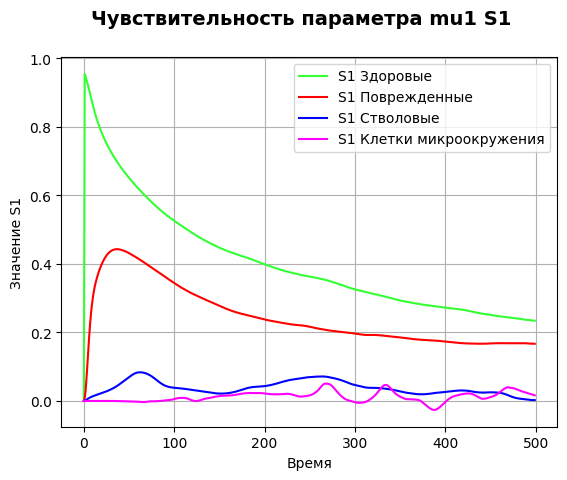

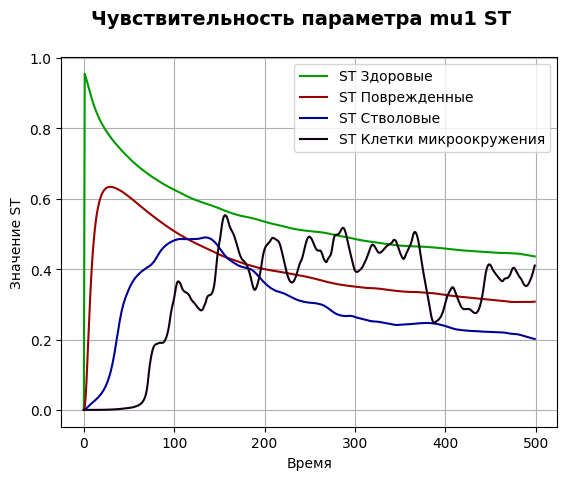

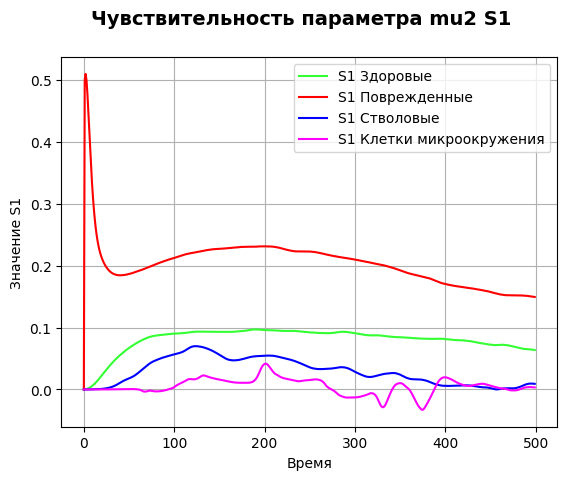

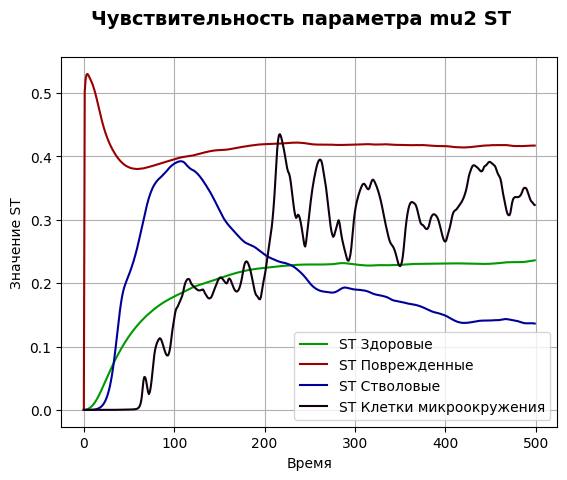

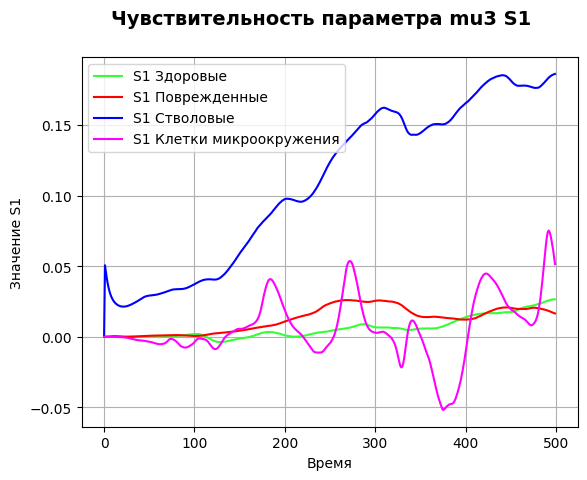

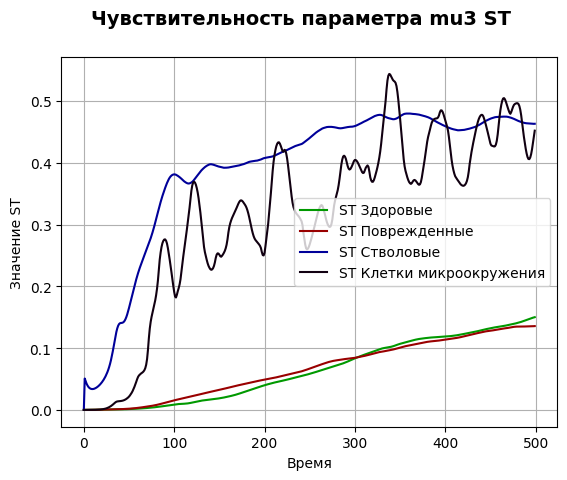

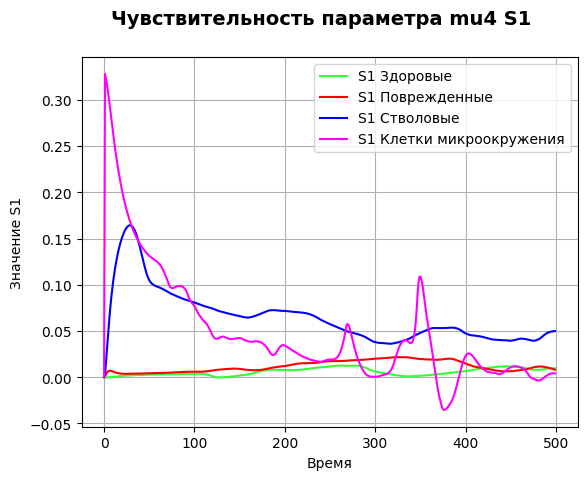

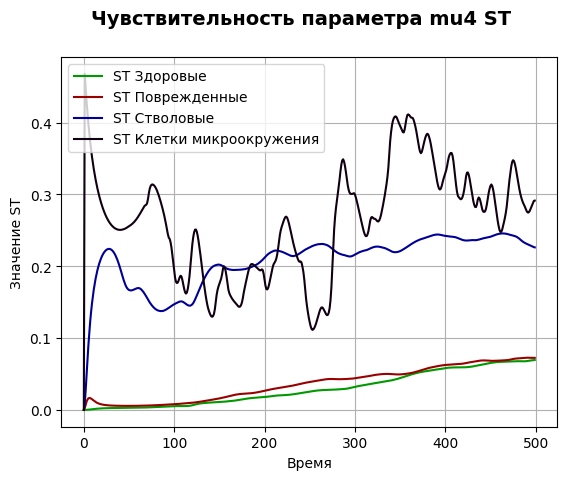

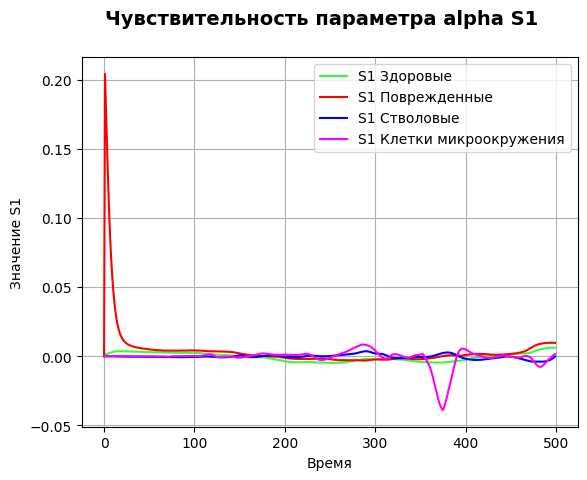

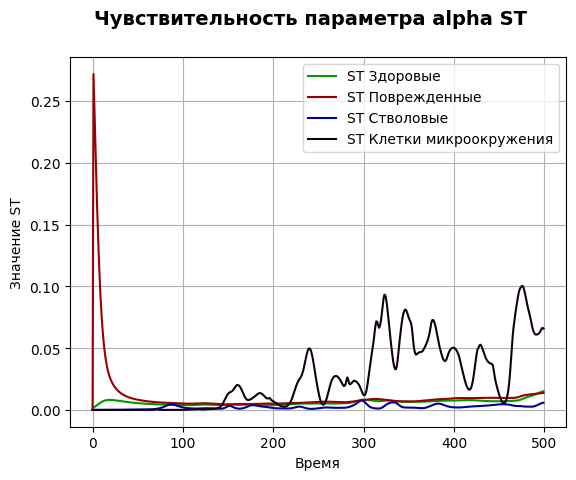

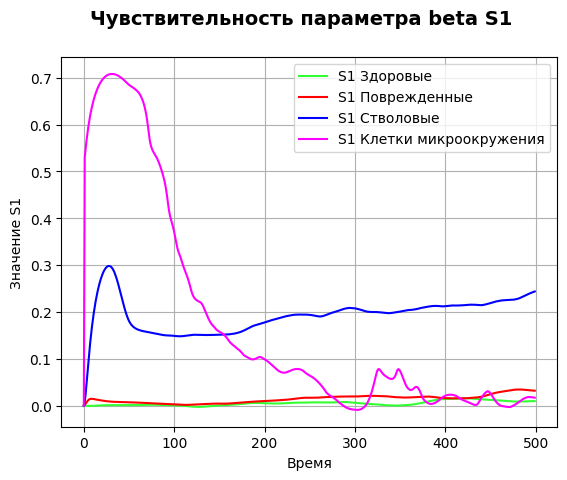

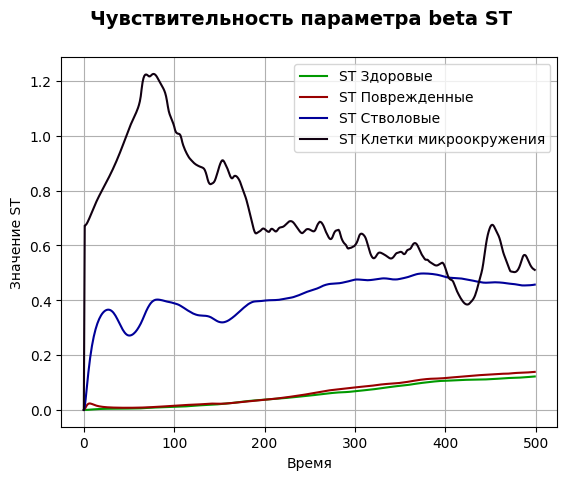

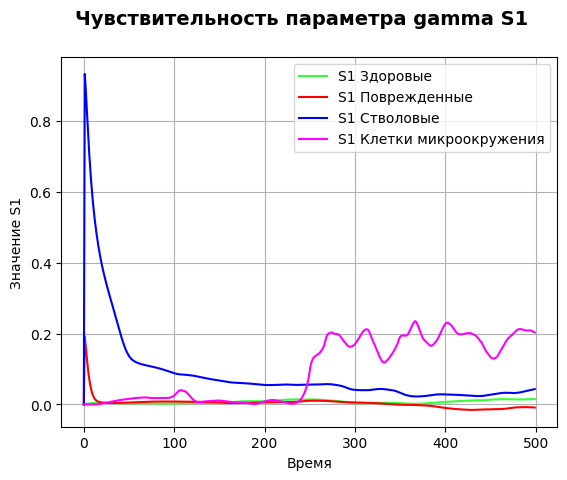

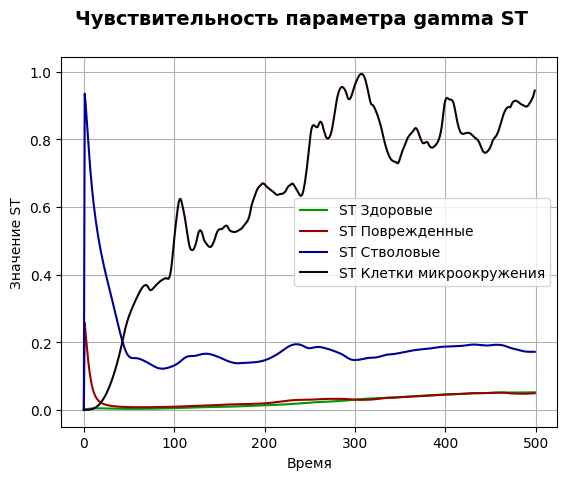

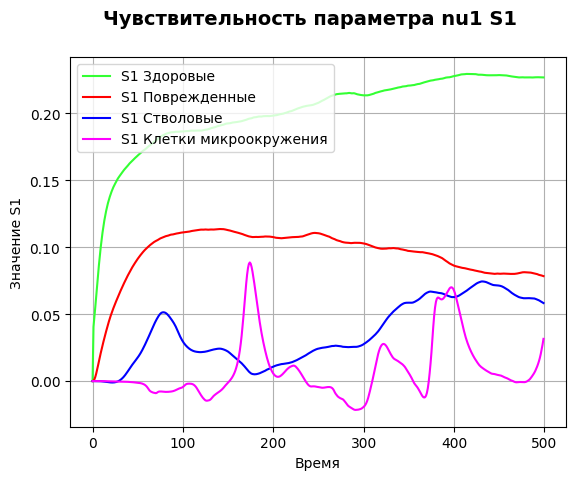

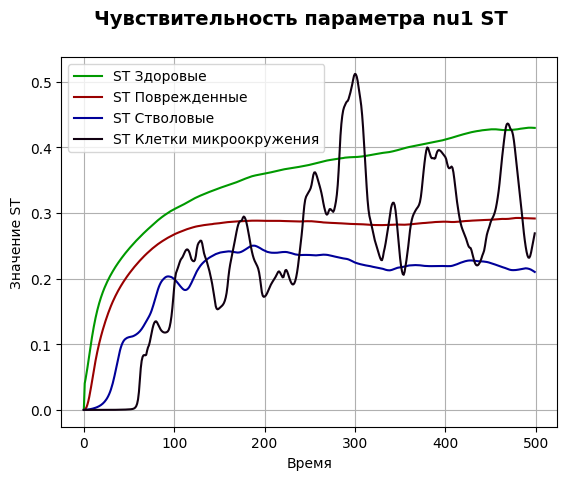

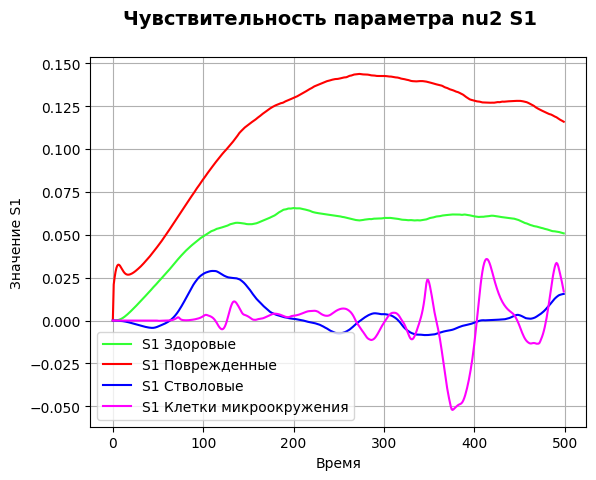

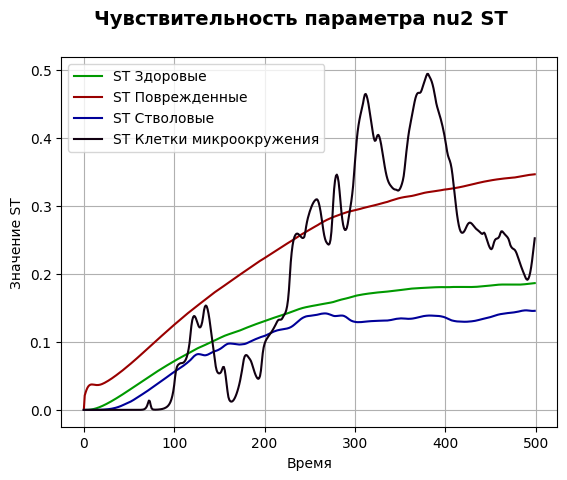

In [28]:
for i in range(9):
    pltS1ST(i)

In [20]:
# Определяем функцию для стилизации
def color_cells(val):
    color = 'yellow' if val > 0.4 else 'green' if val > 0.2 else 'white'
    return f'color: {color}'
def df_SI1T(S1, ST):
    data = [[S1[-1,i] for i in range(len(problem['names']))], [ST[-1,i] for i in range(len(problem['names']))]]
    df = pd.DataFrame(data=data, columns=problem['names'], index=['S1', 'ST'])
    return df.style.map(color_cells)

In [21]:
df_SI1T(SIH1, SIHT)

,mu1,mu2,mu3,mu4,alpha,beta,gamma,nu1,nu2
S1,0.234137,0.063646,0.026560,0.009653,0.006155,0.009505,0.014973,0.226945,0.050826
ST,0.436248,0.235890,0.150069,0.069523,0.015127,0.122014,0.052235,0.429415,0.186377


In [22]:
df_SI1T(SID1, SIDT)

,mu1,mu2,mu3,mu4,alpha,beta,gamma,nu1,nu2
S1,0.166907,0.149317,0.016553,0.008174,0.009662,0.031654,-0.008439,0.078441,0.115912
ST,0.307670,0.416861,0.135652,0.072485,0.013819,0.138790,0.049371,0.291477,0.346335


In [23]:
df_SI1T(SIS1, SIST)

,mu1,mu2,mu3,mu4,alpha,beta,gamma,nu1,nu2
S1,0.002395,0.009100,0.186089,0.049908,-0.000220,0.243646,0.043470,0.058318,0.015528
ST,0.201648,0.136235,0.463026,0.226287,0.005859,0.457167,0.171906,0.210078,0.145663


In [24]:
df_SI1T(SIA1, SIAT)

,mu1,mu2,mu3,mu4,alpha,beta,gamma,nu1,nu2
S1,0.016351,0.003272,0.051532,0.004035,0.001478,0.016804,0.203382,0.031561,0.016961
ST,0.410313,0.323165,0.451877,0.291429,0.065884,0.510857,0.944510,0.268847,0.252265
